<a href="https://colab.research.google.com/github/LukyLuke92/freeCodeCamp-files-LR/blob/main/MachineLearningWithPython/BookRecommendationEngine/fcc_book_recommendation_knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# import libraries (you may add additional imports but you may not have to)
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [5]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/books/book-crossings.zip

!unzip book-crossings.zip

books_filename = 'BX-Books.csv'
ratings_filename = 'BX-Book-Ratings.csv'

--2024-06-16 22:11:10--  https://cdn.freecodecamp.org/project-data/books/book-crossings.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 172.67.70.149, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26085508 (25M) [application/zip]
Saving to: ‘book-crossings.zip.2’

book-crossings.zip. 100%[===================>]  24.88M   121MB/s    in 0.2s    

2024-06-16 22:11:10 (121 MB/s) - ‘book-crossings.zip.2’ saved [26085508/26085508]

Archive:  book-crossings.zip
replace BX-Book-Ratings.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [42]:
# import csv data into dataframes
df_books = pd.read_csv(
    books_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})

In [154]:
# Take a look at the books dataframe
df_books

,isbn,title,author
0,0195153448,Classical Mythology,Mark P. O. Morford
1,0002005018,Clara Callan,Richard Bruce Wright
2,0060973129,Decision in Normandy,Carlo D'Este
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata
4,0393045218,The Mummies of Urumchi,E. J. W. Barber
...,...,...,...
271373,0449906736,Flashpoints: Promise and Peril in a New World,Robin Wright
271375,0525447644,From One to One Hundred,Teri Sloat
271376,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker
271377,0192126040,Republic (World's Classics),Plato


In [28]:
# Take a look at the ratings dataframe
df_ratings

,user,isbn,rating
0,276725,034545104X,0.0
1,276726,0155061224,5.0
2,276727,0446520802,0.0
3,276729,052165615X,3.0
4,276729,0521795028,6.0
...,...,...,...
1149775,276704,1563526298,9.0
1149776,276706,0679447156,0.0
1149777,276709,0515107662,10.0
1149778,276721,0590442449,10.0


(array([3.40436e+05, 1.00000e+02, 1.70000e+01, 1.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([1.0000e+00, 2.5110e+02, 5.0120e+02, 7.5130e+02, 1.0014e+03,
        1.2515e+03, 1.5016e+03, 1.7517e+03, 2.0018e+03, 2.2519e+03,
        2.5020e+03]),
 <BarContainer object of 10 artists>)

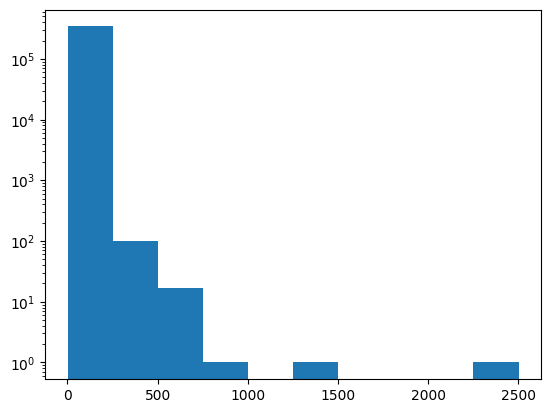

In [29]:
# Plot the number of times each book has been rated
plt.hist(df_ratings.groupby(by='isbn')['rating'].count(),log=True)

In [43]:
# The vast majority of books have few to no reviews - select those that have 100 or more
ratings_counts = df_ratings.groupby('isbn')['rating'].count()
high_books = ratings_counts[ratings_counts >= 100]
print(high_books)

isbn
002542730X    171
0060008032    104
0060096195    107
006016848X    147
0060173289    130
             ... 
1573227331    105
1573229326    217
1573229571    106
1592400876    120
1878424319    133
Name: rating, Length: 731, dtype: int64


In [44]:
# Similar to above, select users with 200 reviews or more
user_rating_counts = df_ratings.groupby('user')['rating'].count()
high_users = user_rating_counts[user_rating_counts >= 200]
# Then select only those ratings that meet the requirements
df_ratings = df_ratings[(df_ratings['user'].isin(high_users.index)) & (df_ratings['isbn'].isin(high_books.index))]
print(df_ratings)

           user        isbn  rating
1456     277427  002542730X    10.0
1469     277427  0060930535     0.0
1471     277427  0060934417     0.0
1474     277427  0061009059     9.0
1484     277427  0140067477     0.0
...         ...         ...     ...
1147304  275970  0804111359     0.0
1147436  275970  140003065X     0.0
1147439  275970  1400031346     0.0
1147440  275970  1400031354     0.0
1147441  275970  1400031362     0.0

[49781 rows x 3 columns]


In [98]:
# Remove duplicates from df_books
df_books = df_books.drop_duplicates(subset='title',keep='first')
# Merge the two dataframes using pandas.merge()
# Use inner join so that only those rows that have a home in both dataframes are joined
df_ratings = pd.merge(df_books,df_ratings,how='inner',on='isbn')

In [81]:
# Rearrange the data so that each book is a separate row, each user is a separate column, and the value is the user's rating of that book
df_ratings_pivot = df_ratings.pivot(columns='user',index='isbn',values='rating')
# Replace NaNs with 0, since nearest neighbors cannot handle NaN values
df_ratings_pivot = df_ratings_pivot.fillna(0) / 10
print(df_ratings_pivot)

user        254     2276    2766    2977    3363    4017    4385    6242    \
isbn                                                                         
002542730X     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
0060008032     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
0060096195     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
006016848X     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
0060173289     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
...            ...     ...     ...     ...     ...     ...     ...     ...   
1573227331     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.6   
1573229326     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.6   
1573229571     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1592400876     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1878424319     0.0     0.0     0.0     0.0     0.0     0.0     0

In [99]:
# Create the nearest neighbors learner
neighbor_finder = NearestNeighbors(metric='cosine')

# Fit the learner to our data
neighbor_finder.fit(df_ratings_pivot)

NearestNeighbors(metric='cosine')

In [178]:
# function to return recommended books - this will be tested
def get_recommends(book = ""):
  isbn_book = df_books[df_books['title'] == book]['isbn'].iloc[0]
  book_row = df_ratings_pivot[df_ratings_pivot.index == isbn_book]
  neighbor_results = neighbor_finder.kneighbors(book_row,n_neighbors=6,return_distance=True)
  idx_list = neighbor_results[1][0]
  distances = neighbor_results[0][0]
  title_list = []
  for i in idx_list:
    isbn = df_ratings_pivot.iloc[i].name
    title_list.append(df_books[df_books['isbn'] == isbn]['title'].item())
  recommended_books = [book,list(reversed([(title, distance) for title, distance in zip(title_list,distances[1:])]))]
  return recommended_books

In [179]:
get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")

["Where the Heart Is (Oprah's Book Club (Paperback))",
 [('The Weight of Water', 0.8016211),
  ('The Surgeon', 0.77085835),
  ('I Know This Much Is True', 0.7699411),
  ('The Lovely Bones: A Novel', 0.7677075),
  ("Where the Heart Is (Oprah's Book Club (Paperback))", 0.7234864)]]

In [180]:
books = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
print(books)

def test_book_recommendation():
  test_pass = True
  recommends = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
  if recommends[0] != "Where the Heart Is (Oprah's Book Club (Paperback))":
    test_pass = False
  recommended_books = ["I'll Be Seeing You", 'The Weight of Water', 'The Surgeon', 'I Know This Much Is True']
  recommended_books_dist = [0.8, 0.77, 0.77, 0.77]
  for i in range(2):
    if recommends[1][i][0] not in recommended_books:
      test_pass = False
    if abs(recommends[1][i][1] - recommended_books_dist[i]) >= 0.05:
      test_pass = False
  if test_pass:
    print("You passed the challenge! 🎉🎉🎉🎉🎉")
  else:
    print("You haven't passed yet. Keep trying!")

test_book_recommendation()

["Where the Heart Is (Oprah's Book Club (Paperback))", [('The Weight of Water', 0.8016211), ('The Surgeon', 0.77085835), ('I Know This Much Is True', 0.7699411), ('The Lovely Bones: A Novel', 0.7677075), ("Where the Heart Is (Oprah's Book Club (Paperback))", 0.7234864)]]
You passed the challenge! 🎉🎉🎉🎉🎉
